<a href="https://colab.research.google.com/github/raitharnett/ML-for-Good-Hackathon-1/blob/main/ml_for_good.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML-for-Good-Hackathon submission
## Team: 6
## Team members: 

1.   Balasubramanian, Karthik
2.   Harnett, Rait
3.   Jones, Ben
4.   Kozin, Igor N
5.   Loffredo, Dom

# Overview

Our approach was to investigate well known techniques to visualize the Child Mind Institute data. We focused on the description parts on a selection of the data:

*   CrisisLogger: `Data/CrisisLogger/crisislogger.csv`
*   ProlificAcademic: `Data/ProlificAcademic/updated_data/April_21/CRISIS_Adult_April_2021.csv`, `Data/ProlificAcademic/updated_data/April_21/CRISIS_Parent_April_2021.csv`

We show how we used the following techniques:

*   Clustering documents with TFIDF and KMeans.
*   A word cloud generator.
*   BERT pre-trained model to predict sentiment.
*   Using ``spaCy`` to analyze transcriptions in the CrisisLogger data.








In [1]:
%%capture
%pip install transformers[sentencepiece] datasets torch tensorflow emoji
%pip install --update spacy
!python -m spacy download en_core_web_sm

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TFAutoModelForSequenceClassification, AutoModelForSeq2SeqLM
import torch
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns; sns.set()  # for plot styling

import ipywidgets as widgets
from collections import defaultdict

from sklearn.cluster import  MiniBatchKMeans, KMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.datasets import make_blobs

from yellowbrick.text import TSNEVisualizer, FreqDistVisualizer
import spacy
from spacy.matcher import PhraseMatcher
import string
import nltk
import nltk.collocations as collocations

from nltk import FreqDist, bigrams
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
nltk.download('stopwords')
nltk.download('punkt')

print(spacy.__version__)  # 3.1.1

Mounted at /content/drive
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
3.0.0


# Clustering documents with TFIDF and KMeans
References:
*   Visulisation details: https://www.kaggle.com/jbencina/clustering-documents-with-tfidf-and-kmeans

*   SSE (Sum of Square Error): https://www.clusteranalysis4marketing.com/interpretation/sum-of-squared-error-sse/

*   Plotting PCA (Principal Component Analysis): https://cran.r-project.org/web/packages/ggfortify/vignettes/plot_pca.html

*   Plotting TSNE: https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b , https://medium.com/analytics-vidhya/pca-vs-t-sne-17bcd882bf3d




In [3]:
crisisLoggerDf = pd.read_csv("/content/drive/MyDrive/ML-for-Good-Hackathon-main/Data/CrisisLogger/crisislogger.csv")
adultApril2021Df = pd.read_csv("/content/drive/MyDrive/ML-for-Good-Hackathon-main/Data/ProlificAcademic/updated_data/April_21/CRISIS_Adult_April_2021.csv")
parentApril2021Df = pd.read_csv("/content/drive/MyDrive/ML-for-Good-Hackathon-main/Data/ProlificAcademic/updated_data/April_21/CRISIS_Parent_April_2021.csv")

In [4]:
# function to find optimal cluster in a range
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
    # plot clusters   
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    plt.show(block=True)

In [5]:
# widget specify max range
check_clusters = widgets.BoundedIntText(
 value=26,
 min=0,
 max=60,
 description='Maximum Clusters to Check:'
 )
display(check_clusters)

BoundedIntText(value=26, description='Maximum Clusters to Check:', max=60)

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters
Fit 22 clusters
Fit 24 clusters
Fit 26 clusters


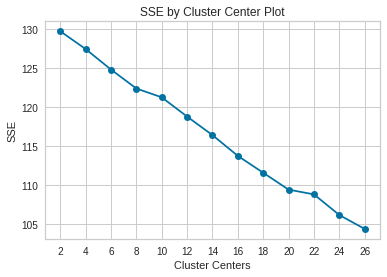

In [6]:
# compute optimal clustering for crisisLogger transcriptions
data = TfidfVectorizer(stop_words='english').fit_transform(crisisLoggerDf['transcriptions'].to_numpy())
max_custers = check_clusters.value
find_optimal_clusters(data, max_custers)

In [7]:
# function to TSNE (T-distributed Stochastic Neighbor Embedding)
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=True)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    plt.show(block=True)

In [8]:
# widget to input optimal cluster from above
cluster_count = widgets.BoundedIntText(
 value=8,
 min=0,
 max=60,
 description='Maximum Clusters to Check:'
 )
display(cluster_count)

BoundedIntText(value=8, description='Maximum Clusters to Check:', max=60)

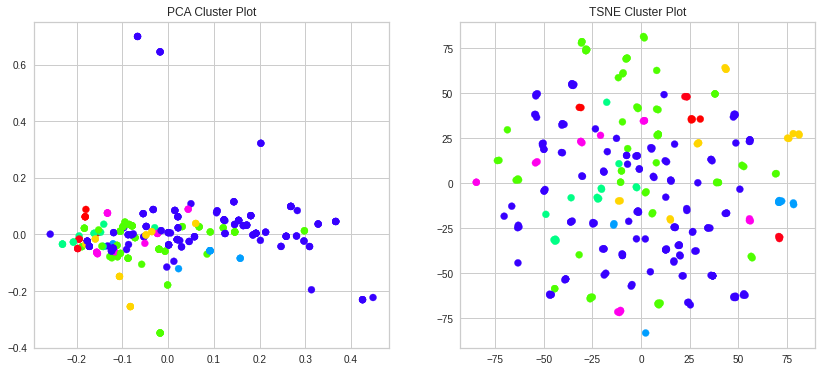

In [9]:
# predicted clusters using 8 clusters and plot clustering
predictedClusters = KMeans(n_clusters=cluster_count.value, init='k-means++', max_iter=100, n_init=1).fit(data).predict(data)
plot_tsne_pca(data, predictedClusters)
# observation: no clear cluster observed!

## Word cloud and frequency plotting 

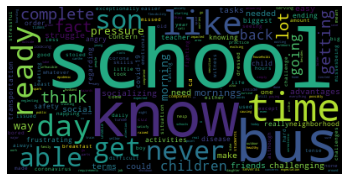

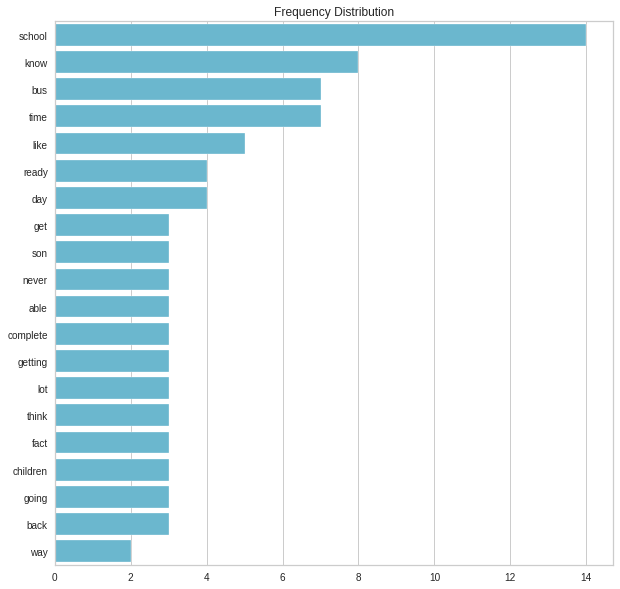

In [10]:
def get_matching_index(labels, match):   
    return np.where(labels == match)

    
def get_cluster_text(document, indexes):   
    returnValue = ""
    for index in indexes:        
        returnValue = returnValue + document[index]
    return " ".join(returnValue)

def get_cluster_text_by_index(labels, index, document):   
    matching_indexes = get_matching_index(labels, index)
    return get_cluster_text(document, matching_indexes) 
  
def generate_word_cloud(text):   
    regular_punct = list(string.punctuation)
    regular_punct.append("'")

    stopwords = nltk.corpus.stopwords.words('english')
    stopwords.append("'m")
    stopwords.append("n't")
    stopwords.append("'s")
    stopwords.append("'re")
    
    tokens = word_tokenize(text)
    vocabulary = set(tokens)            
    tokens = [w.lower() for w in tokens if not w.lower() in stopwords and not w in regular_punct]
    frequency_dist = nltk.FreqDist(tokens)
     
    wordcloud = WordCloud()  
    wordcloud.generate_from_frequencies(frequency_dist)
    
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show(block=True)
  
def generate_word_bar(text):   
    regular_punct = list(string.punctuation)
    regular_punct.append("'")

    stopwords = nltk.corpus.stopwords.words('english')
    stopwords.append("'m")
    stopwords.append("n't")
    stopwords.append("'s")
    stopwords.append("'re")
    
    tokens = word_tokenize(text)
    vocabulary = set(tokens)            
    tokens = [w.lower() for w in tokens if not w.lower() in stopwords and not w in regular_punct]
    frequency_dist = nltk.FreqDist(tokens)
    top_20 = frequency_dist.most_common(20)
    all_fdist = pd.Series(dict(top_20))
    ngram_sorted = {k:v for k,v in sorted(all_fdist.items(), key=lambda item:item[1], reverse=True)}
    ngram_freqdist = pd.Series(ngram_sorted)
        
    fig, ax = plt.subplots(figsize=(10,10))
    bar_plot = sns.barplot(x=ngram_freqdist.values, y=ngram_freqdist.index, orient='h', ax=ax, color='#5bc0de')
    plt.title('Frequency Distribution')
    plt.show(block=True);

# Interactive function to display word cloud and bar graph of word frequency
def show_clusters_word_cloud(document, labels):
    options = ['select a cluster']
    for i in np.unique(labels):
        options.append(i)
    sel = widgets.Select(
     options=options,     
     rows=len(options),
     description='Cluster'
     )      
    output = widgets.Output()
    display(sel,output)    
    def on_value_change(change):
        with output:      
            
            if change['new'] != 'select a cluster':
                print('cluster' + str(change['new']) + ':')
                generate_word_cloud(get_cluster_text_by_index(labels,change['new'], document))
                generate_word_bar(get_cluster_text_by_index(labels,change['new'], document))                                   
    sel.observe(on_value_change, names='value')

# show_clusters_word_cloud(crisisLoggerDf['transcriptions'].to_numpy(), predictedClusters)

cluster = 4
doc = crisisLoggerDf['transcriptions'].to_numpy()
generate_word_cloud(get_cluster_text_by_index(predictedClusters, cluster, doc))
generate_word_bar(get_cluster_text_by_index(predictedClusters, cluster, doc))

# BERT pretrained module: `rabindralamsal/finetuned-bertweet-sentiment-analysis`
This model has been trained on English Tweets (cased) and COVID-19 English Tweets (cased) - that being so, we feel it should provide us with a good indication of the sentiment of the CrisisLogger `transcription` data and well as the `['challenges','benefits','anything_else']` descriptive columns in `Data/ProlificAcademic/updated_data/April_21/CRISIS_Parent_April_2021.csv`

We also extracted phrases from the CrisisLogger `transcription` data containing what we thought would be CV-19 key words:` ["work", "family", "kids", "safe"]`. We then use our pretrained BERT model to predict the sentiment of these phrases.  

In [11]:
tokenizer = AutoTokenizer.from_pretrained("rabindralamsal/finetuned-bertweet-sentiment-analysis")
model = TFAutoModelForSequenceClassification.from_pretrained("rabindralamsal/finetuned-bertweet-sentiment-analysis")

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at rabindralamsal/finetuned-bertweet-sentiment-analysis.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [12]:
# mapping of prediction values to readable sentiment values
sentiment_map = { 0:'negative', 1:'neutral', 2:'positive', 3:'unknown'}
color_map = ['#d9534f','#5bc0de','#5cb85c', '#b8985c']
def sentiment_score(transcription):
  if (not transcription) or pd.isnull(transcription):
    return sentiment_map[3]
  tokens =  tokenizer.encode(transcription, padding=True, truncation=True, max_length=128, return_tensors="tf")
  result =  model.predict(tokens)[0]
  prediction = tf.nn.softmax(result, axis=1).numpy()
  sentiment = np.argmax(prediction)
  return sentiment_map[int(sentiment)]

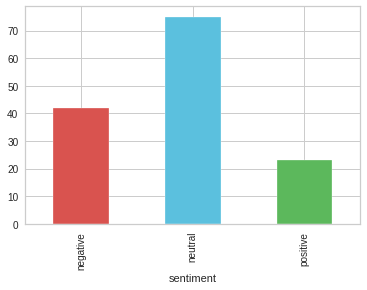

In [13]:
crisisLoggerDf['sentiment'] = crisisLoggerDf['transcriptions'].apply(lambda t: sentiment_score(t))
crisisLoggerDf.groupby('sentiment')['transcriptions'].count().plot(kind='bar',color=color_map)

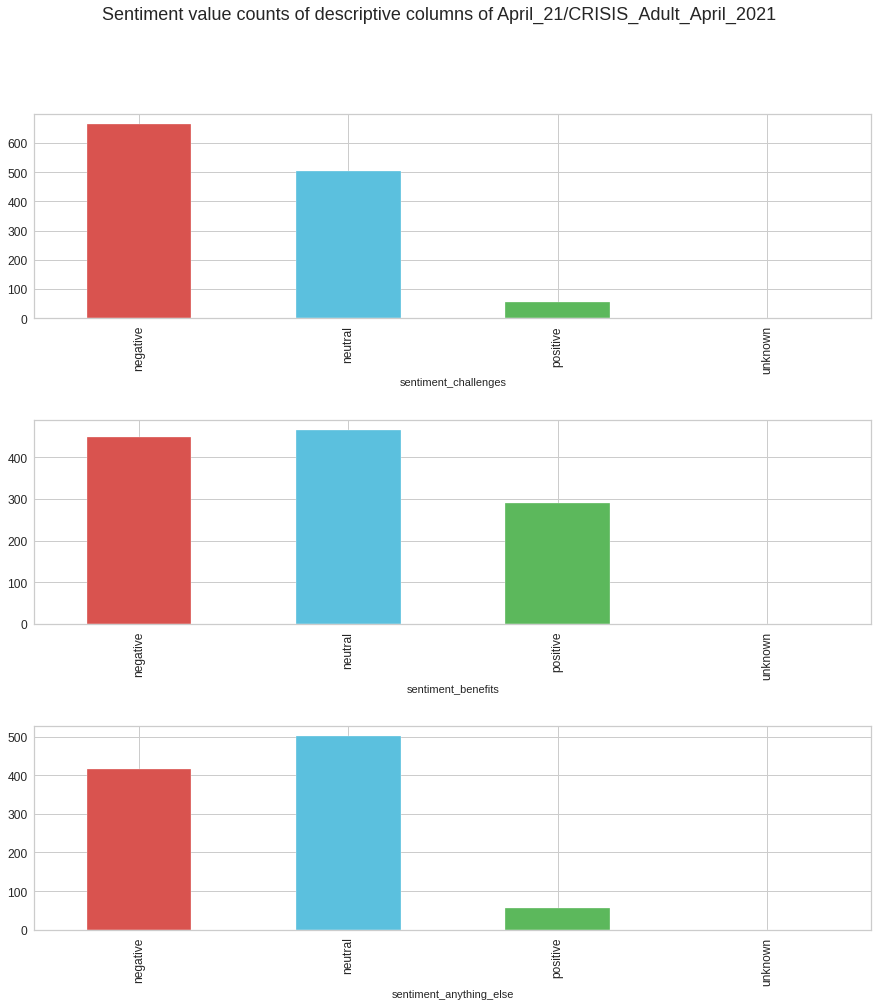

In [14]:
parentApril2021DescriptiveColumns = ['challenges','benefits','anything_else']
fig, axs = plt.subplots(nrows=len(parentApril2021DescriptiveColumns),figsize=(15,15))
fig.suptitle("Sentiment value counts of descriptive columns of April_21/CRISIS_Adult_April_2021", fontsize=18)
plt.subplots_adjust(hspace=0.50)
for index, column in enumerate(parentApril2021DescriptiveColumns):
  sentiment_column = f'sentiment_{column}'
  parentApril2021Df[sentiment_column] = parentApril2021Df[column].apply(lambda t: sentiment_score(t))
  parentApril2021Df.groupby(sentiment_column)[column].count().plot(kind='bar',color=color_map, ax=axs[index], xlabel=sentiment_column, fontsize=12)

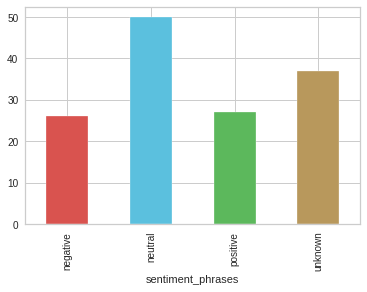

In [15]:
# Focus on phrases which contain key words related to CV-19 concerns
import en_core_web_sm
nlp = en_core_web_sm.load()

# create a matcher which extracts and joins all sentances in a 
# transcription which contain the key words "work", "family", "safe", etc.
crisislogger_matcher = PhraseMatcher(nlp.vocab)
crisislogger_phrases = [nlp("work"), nlp("family"), nlp("kids"), nlp("safe")]
matched_sents = []
def on_match(matcher, doc, i, matches):
  match_id, start, end = matches[i]
  matched_sents.append(doc[start:end].sent.text)
crisislogger_matcher.add("KeyWords", crisislogger_phrases, on_match=on_match)


def crisislogger_phrases(transcription):
  doc = nlp(transcription)
  matched_sents.clear()
  crisislogger_matcher(doc)
  return ".".join(matched_sents)

# extract key word sentance and calculate sentiment - if a transcription
# contains no key works we mark it as "unknown" sentiment
crisisLoggerDf['phrases'] = crisisLoggerDf['transcriptions'].apply(lambda t: crisislogger_phrases(t))
crisisLoggerDf['sentiment_phrases'] = crisisLoggerDf['phrases'].apply(lambda t: sentiment_score(t))
crisisLoggerDf.groupby('sentiment_phrases')['transcriptions'].count().plot(kind='bar',color=color_map)

country      country                                 1.000000
             age                                     0.033816
             gender                                 -0.085763
             tall                                   -0.076412
             measurementheight                      -0.096675
                                                       ...   
Apr_cms_ave  iat_20                                  0.350738
             internet_addiction_test_iat_complete   -0.008357
             inpersonconvo_bin                      -0.101901
             Apr_cw_ave                              0.437820
             Apr_cms_ave                             1.000000
Length: 69696, dtype: float64


exposed___4              exposed___1               -0.825396
exposed___1              exposed___4               -0.825396
relaxedvsanxious         Apr_cms_ave               -0.797200
Apr_cms_ave              relaxedvsanxious          -0.797200
school___1               schooldevice___1          -0.790977
schooldevice___1         school___1                -0.790977
diagnosedfamilytime___2  diagnosedfamily___4       -0.771342
diagnosedfamily___4      diagnosedfamilytime___2   -0.771342
Apr_cms_ave              happyvssad                -0.767759
happyvssad               Apr_cms_ave               -0.767759
weight                   measurementweight         -0.739211
measurementweight        weight                    -0.739211
diagnosedfamily___2      diagnosedfamily___4       -0.729901
diagnosedfamily___4      diagnosedfamily___2       -0.729901
Apr_cms_ave              concentratefocus          -0.702941
concentratefocus         Apr_cms_ave               -0.702941
school___1              

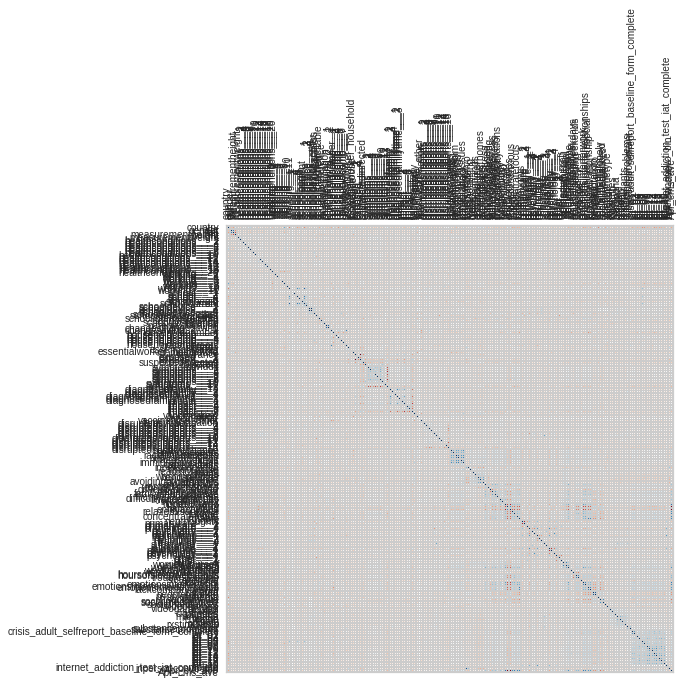

In [16]:
# basic column correlation plots
corr = adultApril2021Df.corr()
fig = plt.figure(figsize=(8,8))
plt.matshow(corr, cmap='RdBu', fignum=fig.number)
plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical');
plt.yticks(range(len(corr.columns)), corr.columns);

corr_pairs = corr.unstack()
print(corr_pairs)

sorted_pairs = corr_pairs.sort_values(kind="quicksort")
sorted_pairs.head(50)

# Using `spaCy` extract new insights from CrisisLogger data
References: http://robertorocha.info/using-nlp-to-analyze-open-ended-responses-in-surveys/

In [17]:
import en_core_web_sm
nlp = en_core_web_sm.load()
nlp.max_length = 1850000
doc = nlp(crisisLoggerDf['transcriptions'].str.cat(sep=' '), disable= ['ner'])

In [18]:
# overall word frequency analysis
from collections import Counter
words = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct] 
word_freq = Counter(words) 
word_freq.most_common(20)

[('know', 285),
 ('time', 185),
 ('like', 183),
 ('go', 174),
 ('school', 169),
 ('work', 163),
 ('think', 139),
 ('home', 131),
 ('thing', 122),
 ('feel', 104),
 ('child', 103),
 ('family', 100),
 ('day', 97),
 ('lot', 89),
 ('kid', 87),
 ('friend', 86),
 ('year', 84),
 ('get', 79),
 ('people', 77),
 ('need', 75)]

In [19]:
# What are the most common adjective-noun phrases?
from spacy.matcher import Matcher 
matcher = Matcher(nlp.vocab) 
pattern = [{'POS':'ADJ'}, {'POS':'NOUN'}] 
matcher.add('ADJ_PHRASE', [pattern]) 
matches = matcher(doc) 
phrases = [] 
for match_id, start, end in matches:
    phrases.append(doc[start:end].text.lower())
    phrase_freq = Counter(phrases)
phrase_freq.most_common(30)

[('little bit', 19),
 ('mental health', 18),
 ('high school', 14),
 ('next year', 11),
 ('other people', 7),
 ('5th grader', 6),
 ('same time', 6),
 ('biggest fear', 5),
 ('front lines', 5),
 ('more time', 5),
 ('last time', 5),
 ('much time', 5),
 ('fresh air', 4),
 ('difficult time', 4),
 ('last year', 4),
 ('immediate family', 4),
 ('older son', 4),
 ('social media', 4),
 ('biggest fears', 4),
 ('many people', 4),
 ('different ways', 4),
 ('other children', 3),
 ('8th grade', 3),
 ('second wave', 3),
 ('only child', 3),
 ('many ways', 3),
 ('single mother', 3),
 ('few months', 3),
 ('few people', 3),
 ('public school', 3)]

In [20]:
# The most common adjective that follow the phrase “I am” or “I feel”
matcher = Matcher(nlp.vocab)
pattern = [{'LOWER' : {'IN' : ['i', 'we']}}, {'OP': '?'}, 
  {'LOWER': {'IN' : ['feel', 'am', "'m", 'are', "'re"]}}, 
  {'OP': '?'}, {'OP': '?'}, {'POS':'ADJ'}]
matcher.add("FeelAdj", [pattern])
matches = matcher(doc)
feel_adj = []
for match_id, start, end in matches:
    feel_adj.extend([token.lemma_ for token in doc[start:end] if token.pos_ == 'ADJ'])
Counter(feel_adj).most_common(20)

[('worried', 16),
 ('lucky', 9),
 ('grateful', 9),
 ('sure', 9),
 ('scared', 8),
 ('little', 8),
 ('able', 7),
 ('frustrated', 5),
 ('healthy', 5),
 ('sad', 4),
 ('fortunate', 4),
 ('okay', 4),
 ('concerned', 4),
 ('glad', 4),
 ('more', 4),
 ('thankful', 3),
 ('angry', 3),
 ('single', 3),
 ('mental', 3),
 ('happy', 3)]

In [21]:
# Looks for phrases that start with “I/we want/need”, followed by a noun, with optional filler words in between
matcher = Matcher(nlp.vocab) 
pattern = [{'LOWER' : {'IN' : ['i', 'we']}}, {'IS_ALPHA':True, 'OP':'?'},
   {'LOWER': {'IN' : ['need', 'want']}}, {'IS_ALPHA':True, 'OP':'?'},
   {'IS_ALPHA':True, 'OP':'?'}, {'POS':'NOUN'}]
matcher.add("WantPhrase", [pattern]) 
matches = matcher(doc)
for match_id, start, end in matches:
  print(doc[start:end])

I would want for our country
I need a break
I just want alone time
we need celebrate a reborn
we definitely need some time
we need strength
I need the biggest struggle
I want to my in
I want number
I want the schools


In [22]:
# The words that most frequently occur near the phrase “mental health”:
from spacy.matcher import PhraseMatcher
mental_health_colloc = []
matcher = PhraseMatcher(nlp.vocab, attr = 'LOWER') 
# The attr above ensures all instances are converted to lower-case so the search is case-insensitive
pattern = [nlp.make_doc('mental health')]
matcher.add('mentalHealth', pattern) 
matches = matcher(doc)
for match_id, start, end in matches:
    span = doc[start-10 : end+10]   
    mental_health_colloc.extend([token.lemma_.lower() for token in span if not token.is_stop and not token.is_punct]) 
Counter(mental_health_colloc).most_common(20)

[('health', 20),
 ('mental', 19),
 ('think', 6),
 ('counseling', 3),
 ('child', 3),
 ('yeah', 3),
 ('like', 3),
 ('day', 3),
 ('counselor', 3),
 ('kid', 3),
 ('issue', 3),
 ('definitely', 3),
 ('know', 3),
 ('good', 3),
 ('happen', 2),
 ('keep', 2),
 ('feel', 2),
 ('online', 2),
 ('have', 2),
 ('suffer', 2)]